<a href="https://colab.research.google.com/github/kh-w/quantum-computing-bootcamp-erdos/blob/main/QC_Boot_Camp_proj_1_Sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Prepare the required packages

%%capture

!pip install qiskit pylatexenc;
!pip install qiskit-aer;

from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister;
from qiskit.quantum_info import Statevector, Operator;

from qiskit_aer import AerSimulator;

from qiskit import transpile;

from qiskit.visualization import plot_histogram;

import pylatexenc;

import matplotlib.pyplot as plt;

import numpy as np;

## Project 1: Solving a $n^2 × n^2$ Sudoku using the Grover's Algorithm.

Suppose the problem to be solved is a specific $2^2 \times 2^2$ Sudoku:

![sudoku_001](https://drive.google.com/uc?id=1Ki0M0Rdc6TbuKKS6T-u14E0q8lFVCD3Z)

Each blank cell can be 1, 2, 3 or 4 so the possibles values of each blank cell can be represented by the basis of a 2-qubit, i.e. \\
$1=\left| 00 \right\rangle=\left| 0 \right\rangle$,\
$2=\left| 01 \right\rangle=\left| 1 \right\rangle$,\
$3=\left| 10 \right\rangle=\left| 2 \right\rangle$,\
$4=\left| 11 \right\rangle=\left| 3 \right\rangle$.\
We have 4 blank cells in this particular Sudoku, so a possible solution consists of 4 numbers, hence all possible solutions(states) can be represented by the basis of $8$-qubit.

i.e. Let $F: \mathbb{F}_2^{8} \rightarrow \mathbb{F}$ be defined as

\begin{equation}
    F(\textbf{x}) = F(x_0, x_1, ..., x_{7}) =
    \begin{cases}
    1 & \text{if }\textbf{x}\text{ solved the Sudoku} \\
    0 & \text{otherwise}
    \end{cases}
\end{equation}

Our goal is the solve the equation
\begin{equation}
    F(\textbf{x}) = 1,
\end{equation}

using Grover's algorithm.

The solution of the Sudoku (from top down, left to right) is: $(2,2,1,1)$ such that the completed Sudoku is:

![sudoku_001_sol](https://drive.google.com/uc?id=1YFK3Q2r4SCdUj27p2JerOaCfKf_E9LpC)

which corresponds to the basis state $\left| 01010000 \right\rangle$, leftmost two bits $01$ represent $2$, next two bits $01$ represent $2$, next two bits $00$ represent $1$ and last two bits $00$ represent $1$. This state should be the most likely state when we observe the final superposition after the Grover's Algorithm.

The initial state therefore is an equal superposition of $\left| x_0x_1...x_{7} \right\rangle$, created by Hadamard gate, $H^{\otimes 8}\left| 00000000 \right\rangle=H^{\otimes 8}\left| 0 \right\rangle_{8}=H^{\otimes 8}\left| 0 \right\rangle$.

Sudoku has some rules on the solution:
- The numbers in each row are distinct
- The numbers in each column are distinct
- The numbers in each $2 × 2$ non-overlapping block are distinct, where the first $2 × 2$ block is at the top-left.

A $2^2 × 2^2$ Sudoku has exactly $4$ rows, columns and blocks respectively.

Fulfilling all the rules means a solution has been found. It is intuitive to create at least 12 ancillas as controls such that a multi-controlled Z gate on these ancillas could flip the phase (mark the state as the solution) when all ancillas are 1s (all rules check out).

Note that the above is for a $2^2 \times 2^2$ Sudoku. When it is a generalized $n^2 \times n^2$ Sudoku:
- number of possible numbers in a blank cell is $n^2$, so it can be represented by the basis of $⌈log_2(n^2)\rceil$-qubit
- all possible states are the basis of $q$-qubit which depends on how many blanks (suppose there are $b$ blanks) has to be filled in: $q=b⌈log_2(n^2)\rceil$
- the number of ancillas would be $3n^2$, i.e. $n^2$ row checks, $n^2$ column checks and $n^2$ block checks.

For example, when $n=3$ and there are 10 blanks:
- number of possible numbers in a blank cell is $9$, so it can be represented by $4$-qubit ($⌈log_2(9)\rceil=4$, since $2^4=16$ is enough to represent 9 numbers. In this case we have 7 redundant basis states.)
- all possible states are the basis of $q$-qubit which depends on how many blanks (we have $10$ blanks in this case) has to be filled in: $q=10⌈log_2(3^2)\rceil=40$, therefore it is the basis of $40$-qubit
- the number of ancillas would be $3(3)^2=27$

In this project, we will only consider a specific $2^2 \times 2^2$ Sudoku problem given above. The circuit design is custom for this problem only. A general circuit design to solve an arbitrary Sudoku problem is doable but that would be a bigger project.

## Step 1: Create a gate that checks if two numbers are the same

This gate is the key component of the marker circuit (the oracle) as a solution checker. A oracle is a blackbox that takes all possible states and all ancillas as input. The output of the oracle would be almost identical to the input except the sign of the state that represents the correct solution will be flipped. Then this output (without the ancillas) will go through diffuser and the output of the diffuser is a superposition that is ready to be observed. The outcome of the observation is very likely to be the correct solution of the Sudoku.

Each ancillas is a check for duplicate numbers on either rows/columns/boxes, i.e. $n^2$ bits. Ancilla is set to 1 if a row/column/box passed a check.

### Step 1.1 Pairwise check and its inverse
Create the following gate, named as $G$, which compares two numbers:
- If the two numbers are the same, set the output to 0
- set the output to 1 otherwise

For each row/column/box, if there are $n^2$ numbers, the required number of check on two numbers is $(n^4-n^2)/2$. When $n=2$, 6 comparisons are required for each row/column/box.



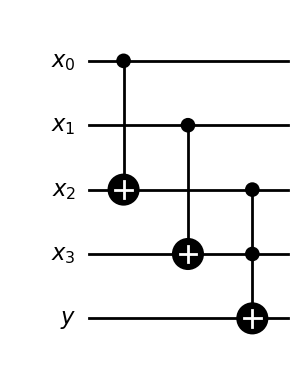

In [2]:
quantum_register = QuantumRegister(size=4, name="x")
ancilla_register = AncillaRegister(size=1, name="y")

pairwise_check = QuantumCircuit(quantum_register, ancilla_register, name="pairwise_check")

pairwise_check.cx(quantum_register[0], quantum_register[2])
pairwise_check.cx(quantum_register[1], quantum_register[3])
pairwise_check.ccx(quantum_register[2], quantum_register[3], ancilla_register[0])

pairwise_check.draw(output="mpl", style="bw")

In [3]:
Pairwise_Check = pairwise_check.to_gate()

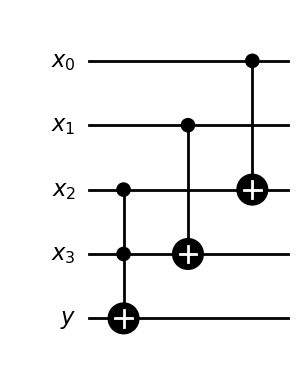

In [4]:
# undo pairwise check

quantum_register = QuantumRegister(size=4, name="x")
ancilla_register = AncillaRegister(size=1, name="y")

inv_pairwise_check = QuantumCircuit(quantum_register, ancilla_register, name="inv_pairwise_check")

inv_pairwise_check.ccx(quantum_register[2], quantum_register[3], ancilla_register[0])
inv_pairwise_check.cx(quantum_register[1], quantum_register[3])
inv_pairwise_check.cx(quantum_register[0], quantum_register[2])

inv_pairwise_check.draw(output="mpl", style="bw")

In [5]:
Inv_Pairwise_Check = inv_pairwise_check.to_gate()

### Step 1.2 Rule check and its inverse

For a $n^2 \times n^2$ Sudoku, each rule check has a $n^2$ numbers input. When $n=2$, each rule check has 4 numbers. The check is to find duplicates within the 4 numbers, the check is good if there are none. The following presents a circuit design for a general rule check (all blanks).

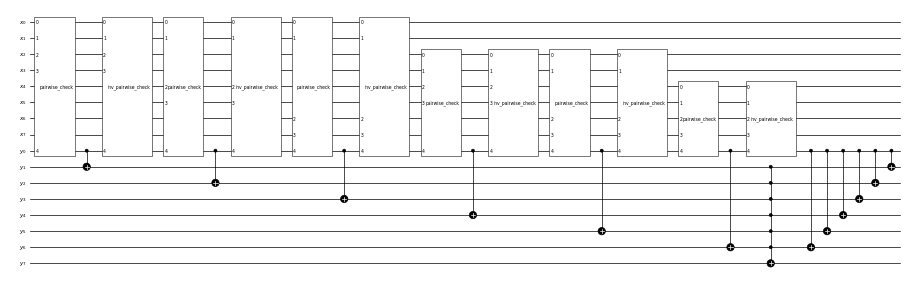

In [6]:
# A general rule check (all blanks)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+0+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 0 reusable ancillas to store number check results (0 is a placeholder to be changed)
                                                             # 1 ancilla stores the MCX output on the 6 ancillas controls
                                                             # afterall: 16-qubit for a 4 numbers check
                                                             # for a 2^2 by 2^2 Sudoku, there are 12 such checks...
                                                             # Question 1: any method to stop process when any different digits are found?

rule_check = QuantumCircuit(quantum_register, ancilla_register, name="rule_check")

## insert problem specific number check

## 0

##

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check.barrier()
  rule_check.cx(ancilla_register[0], # reusable ancilla 1
                ancilla_register[i+1]) # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check.barrier()
  rule_check.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check.barrier()

rule_check.mcx(ancilla_register[1:7],
               ancilla_register[7])    # ancilla_register[7] stores the check for all comparison (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check.cx(ancilla_register[0],
                ancilla_register[i+1])

rule_check.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

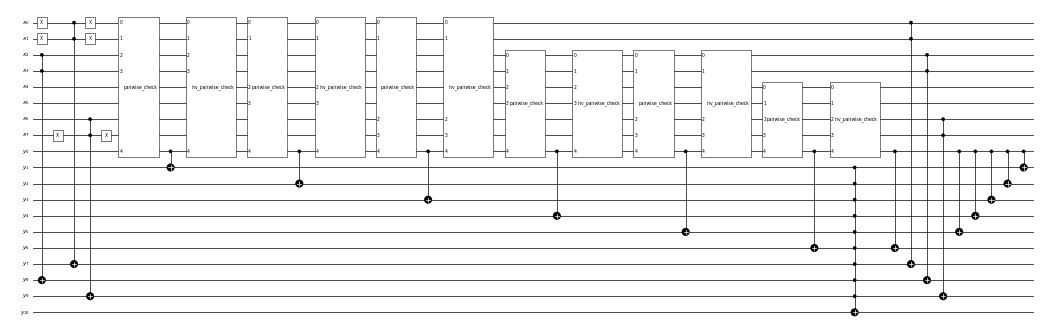

In [7]:
# A rule check for Row 1 (1,4,3,x)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_R1 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_R1")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

## quantum_register[0] and quantum_register[1] should be 0 and 0 respectively to represent 1

rule_check_R1.x(quantum_register[0])
rule_check_R1.x(quantum_register[1])
rule_check_R1.mcx(quantum_register[0:2], ancilla_register[7])
rule_check_R1.x(quantum_register[1])
rule_check_R1.x(quantum_register[0])

## quantum_register[2] and quantum_register[3] should be 1 and 1 respectively to represent 4

rule_check_R1.mcx(quantum_register[2:4], ancilla_register[8])

## quantum_register[6] and quantum_register[7] should be 1 and 0 respectively to represent 3

rule_check_R1.x(quantum_register[7])
rule_check_R1.mcx(quantum_register[6:8], ancilla_register[9])
rule_check_R1.x(quantum_register[7])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_R1.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_R1.barrier()
  rule_check_R1.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_R1.barrier()
  rule_check_R1.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_R1.barrier()

rule_check_R1.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_R1.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_R1.mcx(quantum_register[0:2], ancilla_register[7])
rule_check_R1.mcx(quantum_register[2:4], ancilla_register[8])
rule_check_R1.mcx(quantum_register[6:8], ancilla_register[9])

rule_check_R1.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

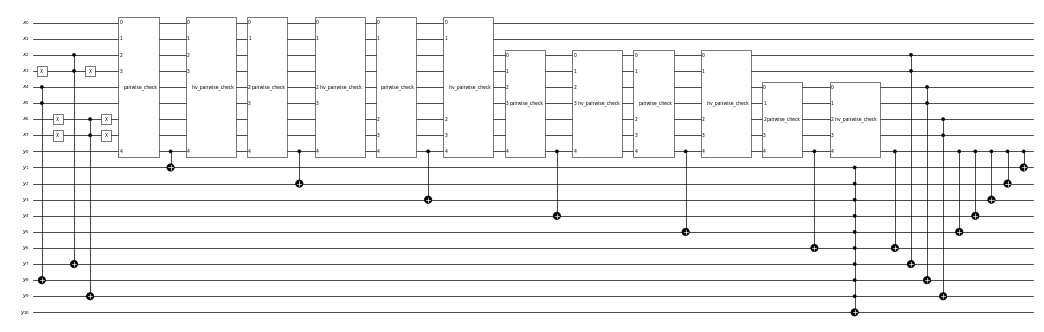

In [8]:
# A rule check for Row 2 (x,3,4,1)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_R2 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_R2")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

## quantum_register[2] and quantum_register[3] should be 1 and 0 respectively to represent 3

rule_check_R2.x(quantum_register[3])
rule_check_R2.mcx(quantum_register[2:4], ancilla_register[7])
rule_check_R2.x(quantum_register[3])

## quantum_register[4] and quantum_register[5] should be 1 and 1 respectively to represent 4

rule_check_R2.mcx(quantum_register[4:6], ancilla_register[8])

## quantum_register[6] and quantum_register[7] should be 0 and 0 respectively to represent 1

rule_check_R2.x(quantum_register[6])
rule_check_R2.x(quantum_register[7])
rule_check_R2.mcx(quantum_register[6:8], ancilla_register[9])
rule_check_R2.x(quantum_register[7])
rule_check_R2.x(quantum_register[6])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_R2.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_R2.barrier()
  rule_check_R2.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_R2.barrier()
  rule_check_R2.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_R2.barrier()

rule_check_R2.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_R2.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_R2.mcx(quantum_register[2:4], ancilla_register[7])
rule_check_R2.mcx(quantum_register[4:6], ancilla_register[8])
rule_check_R2.mcx(quantum_register[6:8], ancilla_register[9])

rule_check_R2.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

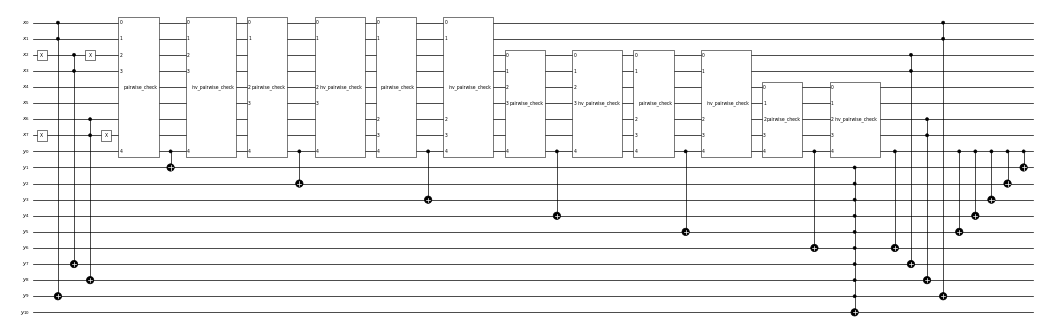

In [9]:
# A rule check for Row 3 (4,2,x,3)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_R3 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_R3")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

# ## quantum_register[2] and quantum_register[3] should be 0 and 0 respectively to represent 1

# rule_check_R3.x(quantum_register[6])
# rule_check_R3.x(quantum_register[7])
# rule_check_R3.mcx(quantum_register[6:8], ancilla_register[9])
# rule_check_R3.x(quantum_register[7])
# rule_check_R3.x(quantum_register[6])

## quantum_register[2] and quantum_register[3] should be 0 and 1 respectively to represent 2

rule_check_R3.x(quantum_register[2])
rule_check_R3.mcx(quantum_register[2:4], ancilla_register[7])
rule_check_R3.x(quantum_register[2])

## quantum_register[6] and quantum_register[7] should be 1 and 0 respectively to represent 3

rule_check_R3.x(quantum_register[7])
rule_check_R3.mcx(quantum_register[6:8], ancilla_register[8])
rule_check_R3.x(quantum_register[7])

## quantum_register[0] and quantum_register[1] should be 1 and 1 respectively to represent 4

rule_check_R3.mcx(quantum_register[0:2], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_R3.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_R3.barrier()
  rule_check_R3.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_R3.barrier()
  rule_check_R3.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_R3.barrier()

rule_check_R3.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_R3.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_R3.mcx(quantum_register[2:4], ancilla_register[7])
rule_check_R3.mcx(quantum_register[6:8], ancilla_register[8])
rule_check_R3.mcx(quantum_register[0:2], ancilla_register[9])

rule_check_R3.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

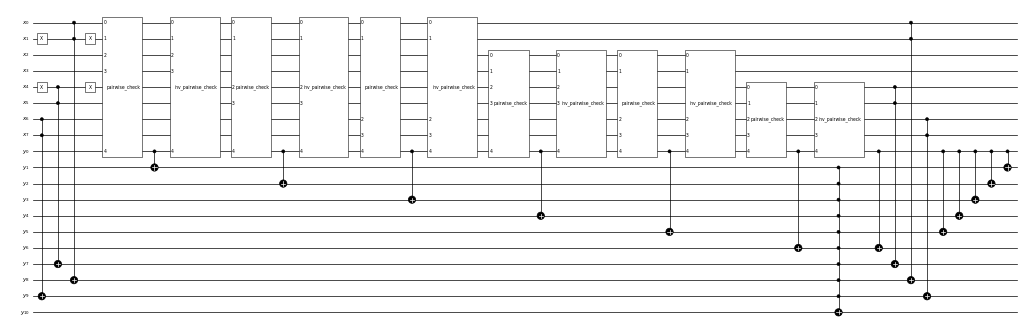

In [10]:
# A rule check for Row 4 (3,x,2,4)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_R4 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_R4")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

# ## quantum_register[2] and quantum_register[3] should be 0 and 0 respectively to represent 1

# rule_check_R4.x(quantum_register[6])
# rule_check_R4.x(quantum_register[7])
# rule_check_R4.mcx(quantum_register[6:8], ancilla_register[9])
# rule_check_R4.x(quantum_register[7])
# rule_check_R4.x(quantum_register[6])

## quantum_register[4] and quantum_register[5] should be 0 and 1 respectively to represent 2

rule_check_R4.x(quantum_register[4])
rule_check_R4.mcx(quantum_register[4:6], ancilla_register[7])
rule_check_R4.x(quantum_register[4])

## quantum_register[0] and quantum_register[1] should be 1 and 0 respectively to represent 3

rule_check_R4.x(quantum_register[1])
rule_check_R4.mcx(quantum_register[0:2], ancilla_register[8])
rule_check_R4.x(quantum_register[1])

## quantum_register[6] and quantum_register[7] should be 1 and 1 respectively to represent 4

rule_check_R4.mcx(quantum_register[6:8], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_R4.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_R4.barrier()
  rule_check_R4.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_R4.barrier()
  rule_check_R4.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_R4.barrier()

rule_check_R4.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_R4.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_R4.mcx(quantum_register[4:6], ancilla_register[7])
rule_check_R4.mcx(quantum_register[0:2], ancilla_register[8])
rule_check_R4.mcx(quantum_register[6:8], ancilla_register[9])

rule_check_R4.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

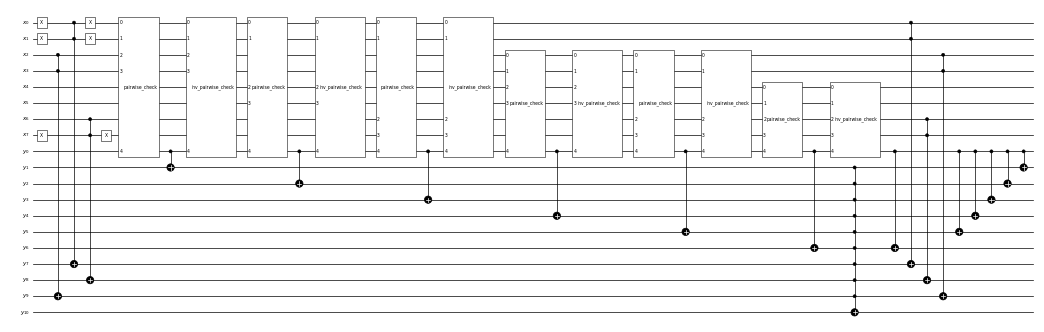

In [11]:
# A rule check for Col 1 (1,x,4,3)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_C1 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_C1")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

## quantum_register[0] and quantum_register[1] should be 0 and 0 respectively to represent 1

rule_check_C1.x(quantum_register[0])
rule_check_C1.x(quantum_register[1])
rule_check_C1.mcx(quantum_register[0:2], ancilla_register[7])
rule_check_C1.x(quantum_register[1])
rule_check_C1.x(quantum_register[0])

# ## quantum_register[4] and quantum_register[5] should be 0 and 1 respectively to represent 2

# rule_check_C1.x(quantum_register[4])
# rule_check_C1.mcx(quantum_register[4:6], ancilla_register[7])
# rule_check_C1.x(quantum_register[4])

## quantum_register[6] and quantum_register[7] should be 1 and 0 respectively to represent 3

rule_check_C1.x(quantum_register[7])
rule_check_C1.mcx(quantum_register[6:8], ancilla_register[8])
rule_check_C1.x(quantum_register[7])

## quantum_register[4] and quantum_register[5] should be 1 and 1 respectively to represent 4

rule_check_C1.mcx(quantum_register[2:4], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_C1.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_C1.barrier()
  rule_check_C1.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_C1.barrier()
  rule_check_C1.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_C1.barrier()

rule_check_C1.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_C1.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_C1.mcx(quantum_register[0:2], ancilla_register[7])
rule_check_C1.mcx(quantum_register[6:8], ancilla_register[8])
rule_check_C1.mcx(quantum_register[2:4], ancilla_register[9])

rule_check_C1.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

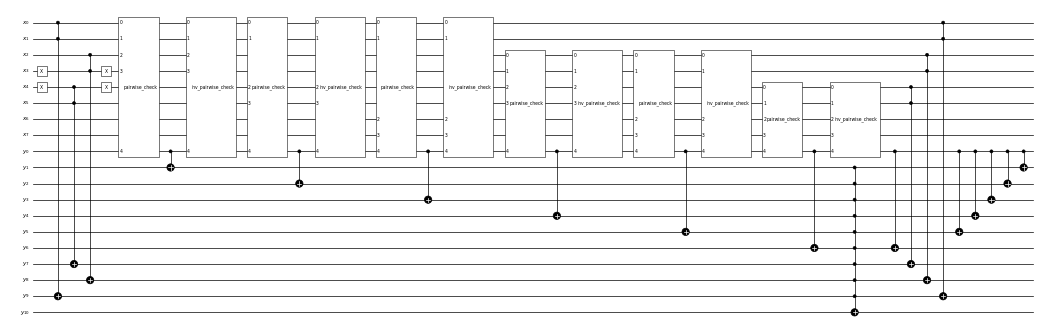

In [12]:
# A rule check for Col 2 (4,3,2,x)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_C2 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_C2")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

# ## quantum_register[0] and quantum_register[1] should be 0 and 0 respectively to represent 1

# rule_check_C2.x(quantum_register[0])
# rule_check_C2.x(quantum_register[1])
# rule_check_C2.mcx(quantum_register[0:2], ancilla_register[7])
# rule_check_C2.x(quantum_register[1])
# rule_check_C2.x(quantum_register[0])

## quantum_register[4] and quantum_register[5] should be 0 and 1 respectively to represent 2

rule_check_C2.x(quantum_register[4])
rule_check_C2.mcx(quantum_register[4:6], ancilla_register[7])
rule_check_C2.x(quantum_register[4])

## quantum_register[2] and quantum_register[3] should be 1 and 0 respectively to represent 3

rule_check_C2.x(quantum_register[3])
rule_check_C2.mcx(quantum_register[2:4], ancilla_register[8])
rule_check_C2.x(quantum_register[3])

## quantum_register[0] and quantum_register[1] should be 1 and 1 respectively to represent 4

rule_check_C2.mcx(quantum_register[0:2], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_C2.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_C2.barrier()
  rule_check_C2.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_C2.barrier()
  rule_check_C2.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_C2.barrier()

rule_check_C2.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_C2.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_C2.mcx(quantum_register[4:6], ancilla_register[7])
rule_check_C2.mcx(quantum_register[2:4], ancilla_register[8])
rule_check_C2.mcx(quantum_register[0:2], ancilla_register[9])

rule_check_C2.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

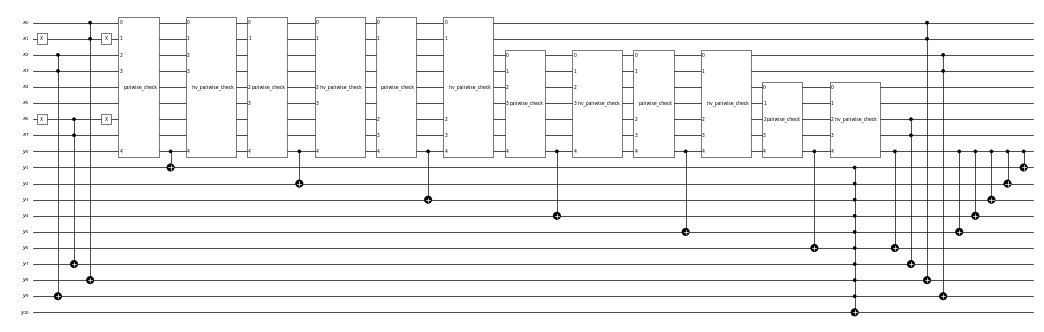

In [13]:
# A rule check for Col 3 (3,4,x,2)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_C3 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_C3")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

# ## quantum_register[0] and quantum_register[1] should be 0 and 0 respectively to represent 1

# rule_check_C3.x(quantum_register[0])
# rule_check_C3.x(quantum_register[1])
# rule_check_C3.mcx(quantum_register[0:2], ancilla_register[7])
# rule_check_C3.x(quantum_register[1])
# rule_check_C3.x(quantum_register[0])

## quantum_register[6] and quantum_register[7] should be 0 and 1 respectively to represent 2

rule_check_C3.x(quantum_register[6])
rule_check_C3.mcx(quantum_register[6:8], ancilla_register[7])
rule_check_C3.x(quantum_register[6])

## quantum_register[0] and quantum_register[1] should be 1 and 0 respectively to represent 3

rule_check_C3.x(quantum_register[1])
rule_check_C3.mcx(quantum_register[0:2], ancilla_register[8])
rule_check_C3.x(quantum_register[1])

## quantum_register[2] and quantum_register[3] should be 1 and 1 respectively to represent 4

rule_check_C3.mcx(quantum_register[2:4], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_C3.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_C3.barrier()
  rule_check_C3.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_C3.barrier()
  rule_check_C3.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_C3.barrier()

rule_check_C3.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_C3.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_C3.mcx(quantum_register[6:8], ancilla_register[7])
rule_check_C3.mcx(quantum_register[0:2], ancilla_register[8])
rule_check_C3.mcx(quantum_register[2:4], ancilla_register[9])

rule_check_C3.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

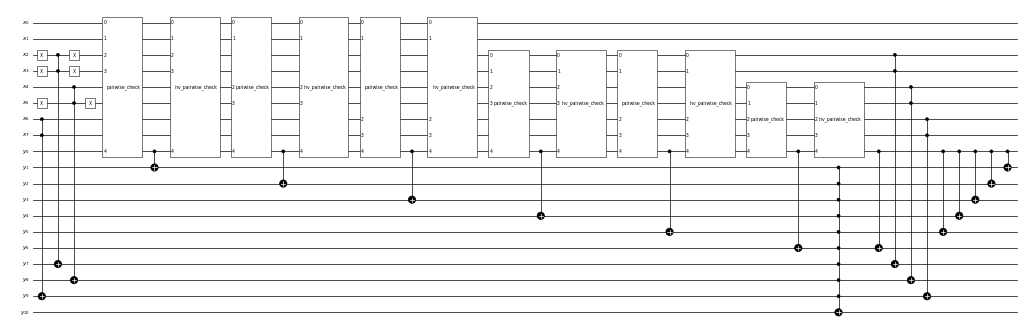

In [14]:
# A rule check for Col 4 (x,1,3,4)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_C4 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_C4")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

## quantum_register[2] and quantum_register[3] should be 0 and 0 respectively to represent 1

rule_check_C4.x(quantum_register[2])
rule_check_C4.x(quantum_register[3])
rule_check_C4.mcx(quantum_register[2:4], ancilla_register[7])
rule_check_C4.x(quantum_register[3])
rule_check_C4.x(quantum_register[2])

# ## quantum_register[6] and quantum_register[7] should be 0 and 1 respectively to represent 2

# rule_check_C4.x(quantum_register[6])
# rule_check_C4.mcx(quantum_register[6:8], ancilla_register[7])
# rule_check_C4.x(quantum_register[6])

## quantum_register[4] and quantum_register[5] should be 1 and 0 respectively to represent 3

rule_check_C4.x(quantum_register[5])
rule_check_C4.mcx(quantum_register[4:6], ancilla_register[8])
rule_check_C4.x(quantum_register[5])

## quantum_register[6] and quantum_register[7] should be 1 and 1 respectively to represent 4

rule_check_C4.mcx(quantum_register[6:8], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_C4.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_C4.barrier()
  rule_check_C4.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_C4.barrier()
  rule_check_C4.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_C4.barrier()

rule_check_C4.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_C4.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_C4.mcx(quantum_register[2:4], ancilla_register[7])
rule_check_C4.mcx(quantum_register[4:6], ancilla_register[8])
rule_check_C4.mcx(quantum_register[6:8], ancilla_register[9])

rule_check_C4.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

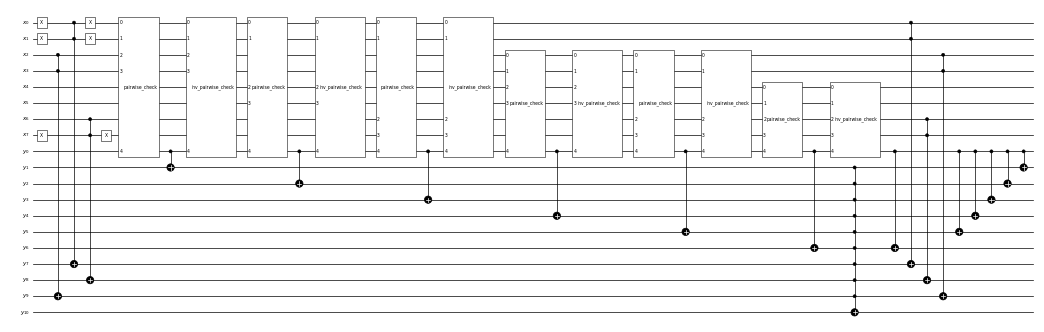

In [15]:
# A rule check for Block 1 (1,4,x,3)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_B1 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_B1")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

## quantum_register[0] and quantum_register[1] should be 0 and 0 respectively to represent 1

rule_check_B1.x(quantum_register[0])
rule_check_B1.x(quantum_register[1])
rule_check_B1.mcx(quantum_register[0:2], ancilla_register[7])
rule_check_B1.x(quantum_register[1])
rule_check_B1.x(quantum_register[0])

# ## quantum_register[6] and quantum_register[7] should be 0 and 1 respectively to represent 2

# rule_check_B1.x(quantum_register[6])
# rule_check_B1.mcx(quantum_register[6:8], ancilla_register[7])
# rule_check_B1.x(quantum_register[6])

## quantum_register[6] and quantum_register[7] should be 1 and 0 respectively to represent 3

rule_check_B1.x(quantum_register[7])
rule_check_B1.mcx(quantum_register[6:8], ancilla_register[8])
rule_check_B1.x(quantum_register[7])

## quantum_register[2] and quantum_register[3] should be 1 and 1 respectively to represent 4

rule_check_B1.mcx(quantum_register[2:4], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_B1.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_B1.barrier()
  rule_check_B1.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_B1.barrier()
  rule_check_B1.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_B1.barrier()

rule_check_B1.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_B1.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_B1.mcx(quantum_register[0:2], ancilla_register[7])
rule_check_B1.mcx(quantum_register[6:8], ancilla_register[8])
rule_check_B1.mcx(quantum_register[2:4], ancilla_register[9])

rule_check_B1.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

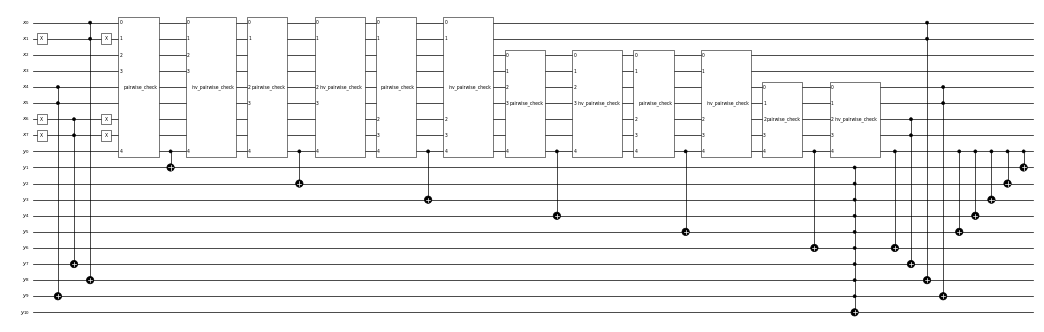

In [16]:
# A rule check for Block 2 (3,x,4,1)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_B2 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_B2")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

## quantum_register[6] and quantum_register[7] should be 0 and 0 respectively to represent 1

rule_check_B2.x(quantum_register[6])
rule_check_B2.x(quantum_register[7])
rule_check_B2.mcx(quantum_register[6:8], ancilla_register[7])
rule_check_B2.x(quantum_register[7])
rule_check_B2.x(quantum_register[6])

# ## quantum_register[6] and quantum_register[7] should be 0 and 1 respectively to represent 2

# rule_check_B2.x(quantum_register[6])
# rule_check_B2.mcx(quantum_register[6:8], ancilla_register[7])
# rule_check_B2.x(quantum_register[6])

## quantum_register[0] and quantum_register[1] should be 1 and 0 respectively to represent 3

rule_check_B2.x(quantum_register[1])
rule_check_B2.mcx(quantum_register[0:2], ancilla_register[8])
rule_check_B2.x(quantum_register[1])

## quantum_register[4] and quantum_register[5] should be 1 and 1 respectively to represent 4

rule_check_B2.mcx(quantum_register[4:6], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_B2.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_B2.barrier()
  rule_check_B2.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_B2.barrier()
  rule_check_B2.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_B2.barrier()

rule_check_B2.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_B2.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_B2.mcx(quantum_register[6:8], ancilla_register[7])
rule_check_B2.mcx(quantum_register[0:2], ancilla_register[8])
rule_check_B2.mcx(quantum_register[4:6], ancilla_register[9])

rule_check_B2.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

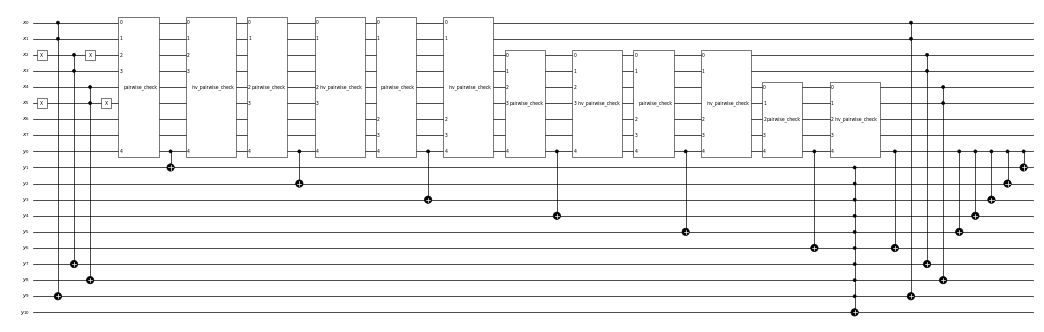

In [17]:
# A rule check for Block 3 (4,2,3,x)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_B3 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_B3")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

# ## quantum_register[6] and quantum_register[7] should be 0 and 0 respectively to represent 1

# rule_check_B3.x(quantum_register[6])
# rule_check_B3.x(quantum_register[7])
# rule_check_B3.mcx(quantum_register[6:8], ancilla_register[7])
# rule_check_B3.x(quantum_register[7])
# rule_check_B3.x(quantum_register[6])

## quantum_register[2] and quantum_register[3] should be 0 and 1 respectively to represent 2

rule_check_B3.x(quantum_register[2])
rule_check_B3.mcx(quantum_register[2:4], ancilla_register[7])
rule_check_B3.x(quantum_register[2])

## quantum_register[4] and quantum_register[5] should be 1 and 0 respectively to represent 3

rule_check_B3.x(quantum_register[5])
rule_check_B3.mcx(quantum_register[4:6], ancilla_register[8])
rule_check_B3.x(quantum_register[5])

## quantum_register[0] and quantum_register[1] should be 1 and 1 respectively to represent 4

rule_check_B3.mcx(quantum_register[0:2], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_B3.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_B3.barrier()
  rule_check_B3.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_B3.barrier()
  rule_check_B3.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_B3.barrier()

rule_check_B3.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_B3.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_B3.mcx(quantum_register[0:2], ancilla_register[9])
rule_check_B3.mcx(quantum_register[2:4], ancilla_register[7])
rule_check_B3.mcx(quantum_register[4:6], ancilla_register[8])

rule_check_B3.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

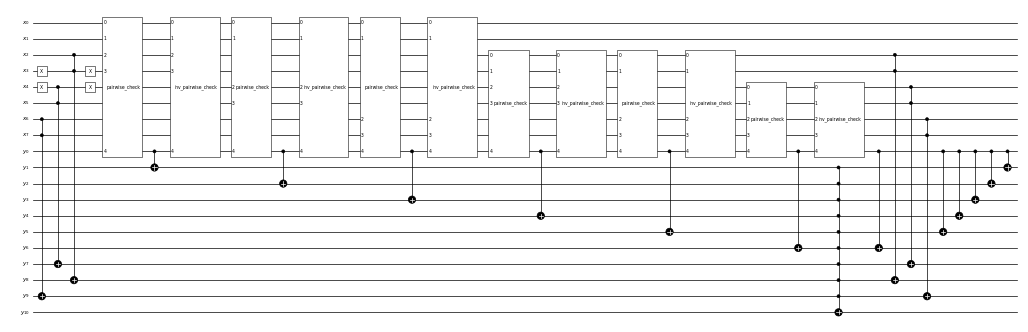

In [18]:
# A rule check for Block 4 (x,3,2,4)

quantum_register = QuantumRegister(size=8, name="x")         # 4 numbers = 8
ancilla_register = AncillaRegister(size=1+6+3+1, name="y")   # 1 resuable ancilla for pairwise check
                                                             # 6 reusable ancillas to store pairwise check results,
                                                             # 3 reusable ancillas to store number check results
                                                             # 1 ancilla stores the MCX output on the 6+3 ancillas controls

rule_check_B4 = QuantumCircuit(quantum_register, ancilla_register, name="rule_check_B4")

##############################################################################

#### Custom design specific to the problem

### insert problem specific number check

# ## quantum_register[6] and quantum_register[7] should be 0 and 0 respectively to represent 1

# rule_check_B4.x(quantum_register[6])
# rule_check_B4.x(quantum_register[7])
# rule_check_B4.mcx(quantum_register[6:8], ancilla_register[7])
# rule_check_B4.x(quantum_register[7])
# rule_check_B4.x(quantum_register[6])

## quantum_register[4] and quantum_register[5] should be 0 and 1 respectively to represent 2

rule_check_B4.x(quantum_register[4])
rule_check_B4.mcx(quantum_register[4:6], ancilla_register[7])
rule_check_B4.x(quantum_register[4])

## quantum_register[2] and quantum_register[3] should be 1 and 0 respectively to represent 3

rule_check_B4.x(quantum_register[3])
rule_check_B4.mcx(quantum_register[2:4], ancilla_register[8])
rule_check_B4.x(quantum_register[3])

## quantum_register[6] and quantum_register[7] should be 1 and 1 respectively to represent 4

rule_check_B4.mcx(quantum_register[6:8], ancilla_register[9])

##############################################################################

for i in range(6):
  # possible pairwise checks with resuable ancilla position
  list = [[quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[0], quantum_register[1], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[4], quantum_register[5], ancilla_register[0]],
          [quantum_register[2], quantum_register[3], quantum_register[6], quantum_register[7], ancilla_register[0]],
          [quantum_register[4], quantum_register[5], quantum_register[6], quantum_register[7], ancilla_register[0]]]
  rule_check_B4.compose(Pairwise_Check, qubits=list[i], inplace=True)
  # rule_check_B4.barrier()
  rule_check_B4.cx(ancilla_register[0],    # reusable ancilla 1
                   ancilla_register[i+1])  # ancilla_register[i+2] stores the check for (i+1)th comparison
  # rule_check_B4.barrier()
  rule_check_B4.compose(Inv_Pairwise_Check, qubits=list[i], inplace=True) # resetting the qubits and the 1 reusable ancilla
  # rule_check_B4.barrier()

rule_check_B4.mcx(ancilla_register[1:10],  # results of all number checks and pairwise checks
                  ancilla_register[10])    # ancilla_register[10] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

for i in range(6)[::-1]: # resetting ancillas for the next rule check
  rule_check_B4.cx(ancilla_register[0],
                   ancilla_register[i+1])
rule_check_B4.mcx(quantum_register[2:4], ancilla_register[8])
rule_check_B4.mcx(quantum_register[4:6], ancilla_register[7])
rule_check_B4.mcx(quantum_register[6:8], ancilla_register[9])

rule_check_B4.draw(output="mpl", style="bw", scale = 0.25, fold=-1)

In [19]:
Rule_Check_R1 = rule_check_R1.to_gate()
Rule_Check_R2 = rule_check_R2.to_gate()
Rule_Check_R3 = rule_check_R3.to_gate()
Rule_Check_R4 = rule_check_R4.to_gate()

Rule_Check_C1 = rule_check_C1.to_gate()
Rule_Check_C2 = rule_check_C2.to_gate()
Rule_Check_C3 = rule_check_C3.to_gate()
Rule_Check_C4 = rule_check_C4.to_gate()

Rule_Check_B1 = rule_check_B1.to_gate()
Rule_Check_B2 = rule_check_B2.to_gate()
Rule_Check_B3 = rule_check_B3.to_gate()
Rule_Check_B4 = rule_check_B4.to_gate()

### Step 1.3 Overall solution check and its inverse

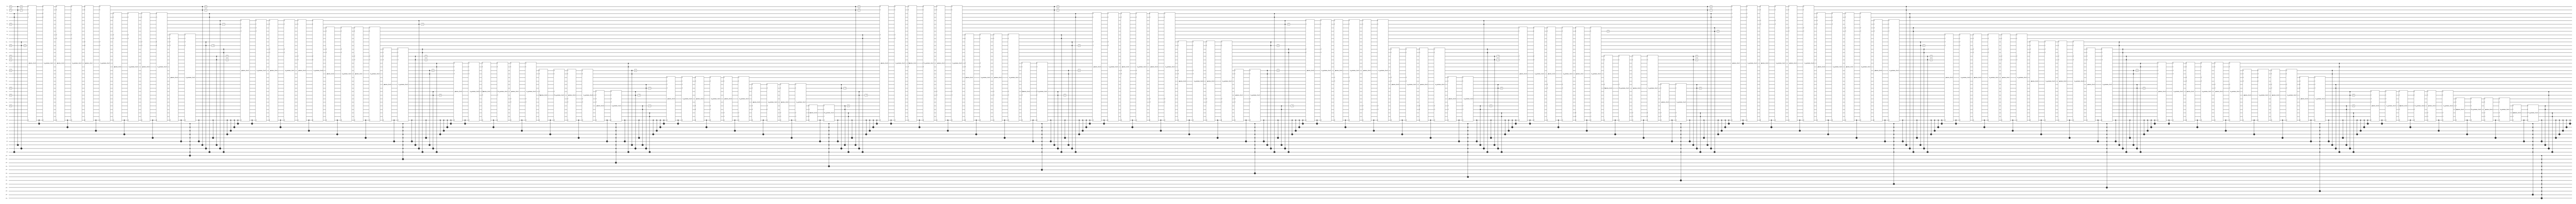

In [20]:
# 12 rule checks on a possible solution

quantum_register = QuantumRegister(size=32, name="x")         # 16 numbers = 32
ancilla_register = AncillaRegister(size=1+6+3+12+1, name="y") # 1+6 reusable ancillas for each rule check, 12 ancillas to store all rule checks results,
                                                              # 1 ancilla for overall result storage, total 20 ancillas

solution_check = QuantumCircuit(quantum_register, ancilla_register, name="solution_check")

list = [[quantum_register[0],quantum_register[1],quantum_register[2],quantum_register[3],
          quantum_register[8],quantum_register[9],quantum_register[10],quantum_register[11], ancilla_register[0],
                                                                                            ancilla_register[1],
                                                                                            ancilla_register[2],
                                                                                            ancilla_register[3],
                                                                                            ancilla_register[4],
                                                                                            ancilla_register[5],
                                                                                            ancilla_register[6],
                                                                                            ancilla_register[7],
                                                                                            ancilla_register[8],
                                                                                            ancilla_register[9], ancilla_register[10]], # B1

        [quantum_register[4],quantum_register[5],quantum_register[6],quantum_register[7],
          quantum_register[12],quantum_register[13],quantum_register[14],quantum_register[15], ancilla_register[0],
                                                                                              ancilla_register[1],
                                                                                              ancilla_register[2],
                                                                                              ancilla_register[3],
                                                                                              ancilla_register[4],
                                                                                              ancilla_register[5],
                                                                                              ancilla_register[6],
                                                                                            ancilla_register[7],
                                                                                            ancilla_register[8],
                                                                                            ancilla_register[9], ancilla_register[11]], # B2

        [quantum_register[16],quantum_register[17],quantum_register[18],quantum_register[19],
          quantum_register[24],quantum_register[25],quantum_register[26],quantum_register[27], ancilla_register[0],
                                                                                              ancilla_register[1],
                                                                                              ancilla_register[2],
                                                                                              ancilla_register[3],
                                                                                              ancilla_register[4],
                                                                                              ancilla_register[5],
                                                                                              ancilla_register[6],
                                                                                            ancilla_register[7],
                                                                                            ancilla_register[8],
                                                                                            ancilla_register[9], ancilla_register[12]], # B3

        [quantum_register[20],quantum_register[21],quantum_register[22],quantum_register[23],
          quantum_register[28],quantum_register[29],quantum_register[30],quantum_register[31], ancilla_register[0],
                                                                                              ancilla_register[1],
                                                                                              ancilla_register[2],
                                                                                              ancilla_register[3],
                                                                                              ancilla_register[4],
                                                                                              ancilla_register[5],
                                                                                              ancilla_register[6],
                                                                                            ancilla_register[7],
                                                                                            ancilla_register[8],
                                                                                            ancilla_register[9], ancilla_register[13]], # B4

        [quantum_register[0],quantum_register[1],
          quantum_register[8],quantum_register[9],
          quantum_register[16],quantum_register[17],
          quantum_register[24],quantum_register[25], ancilla_register[0],
                                                    ancilla_register[1],
                                                    ancilla_register[2],
                                                    ancilla_register[3],
                                                    ancilla_register[4],
                                                    ancilla_register[5],
                                                    ancilla_register[6],
                                                    ancilla_register[7],
                                                    ancilla_register[8],
                                                    ancilla_register[9], ancilla_register[14]], # C1

        [quantum_register[2],quantum_register[3],
          quantum_register[10],quantum_register[11],
          quantum_register[18],quantum_register[19],
          quantum_register[26],quantum_register[27], ancilla_register[0],
                                                    ancilla_register[1],
                                                    ancilla_register[2],
                                                    ancilla_register[3],
                                                    ancilla_register[4],
                                                    ancilla_register[5],
                                                    ancilla_register[6],
                                                    ancilla_register[7],
                                                    ancilla_register[8],
                                                    ancilla_register[9], ancilla_register[15]], # C2

        [quantum_register[4],quantum_register[5],
          quantum_register[12],quantum_register[13],
          quantum_register[20],quantum_register[21],
          quantum_register[28],quantum_register[29], ancilla_register[0],
                                                    ancilla_register[1],
                                                    ancilla_register[2],
                                                    ancilla_register[3],
                                                    ancilla_register[4],
                                                    ancilla_register[5],
                                                    ancilla_register[6],
                                                    ancilla_register[7],
                                                    ancilla_register[8],
                                                    ancilla_register[9], ancilla_register[16]], # C3

        [quantum_register[6],quantum_register[7],
          quantum_register[14],quantum_register[15],
          quantum_register[22],quantum_register[23],
          quantum_register[30],quantum_register[31], ancilla_register[0],
                                                    ancilla_register[1],
                                                    ancilla_register[2],
                                                    ancilla_register[3],
                                                    ancilla_register[4],
                                                    ancilla_register[5],
                                                    ancilla_register[6],
                                                    ancilla_register[7],
                                                    ancilla_register[8],
                                                    ancilla_register[9], ancilla_register[17]], # C4

        [quantum_register[0],quantum_register[1],quantum_register[2],quantum_register[3],quantum_register[4],quantum_register[5],quantum_register[6],quantum_register[7],ancilla_register[0],
                                                                                                                                                                          ancilla_register[1],
                                                                                                                                                                          ancilla_register[2],
                                                                                                                                                                          ancilla_register[3],
                                                                                                                                                                          ancilla_register[4],
                                                                                                                                                                          ancilla_register[5],
                                                                                                                                                                          ancilla_register[6],
                                                                                                                                                                          ancilla_register[7],
                                                                                                                                                                          ancilla_register[8],
                                                                                                                                                                          ancilla_register[9], ancilla_register[18]], # R1

        [quantum_register[8],quantum_register[9],quantum_register[10],quantum_register[11],quantum_register[12],quantum_register[13],quantum_register[14],quantum_register[15],ancilla_register[0],
                                                                                                                                                                                ancilla_register[1],
                                                                                                                                                                                ancilla_register[2],
                                                                                                                                                                                ancilla_register[3],
                                                                                                                                                                                ancilla_register[4],
                                                                                                                                                                                ancilla_register[5],
                                                                                                                                                                                ancilla_register[6],
                                                                                                                                                                          ancilla_register[7],
                                                                                                                                                                          ancilla_register[8],
                                                                                                                                                                          ancilla_register[9], ancilla_register[19]], # R2

        [quantum_register[16],quantum_register[17],quantum_register[18],quantum_register[19],quantum_register[20],quantum_register[21],quantum_register[22],quantum_register[23],ancilla_register[0],
                                                                                                                                                                                  ancilla_register[1],
                                                                                                                                                                                  ancilla_register[2],
                                                                                                                                                                                  ancilla_register[3],
                                                                                                                                                                                  ancilla_register[4],
                                                                                                                                                                                  ancilla_register[5],
                                                                                                                                                                                  ancilla_register[6],
                                                                                                                                                                          ancilla_register[7],
                                                                                                                                                                          ancilla_register[8],
                                                                                                                                                                          ancilla_register[9], ancilla_register[20]], # R3

        [quantum_register[24],quantum_register[25],quantum_register[26],quantum_register[27],quantum_register[28],quantum_register[29],quantum_register[30],quantum_register[31],ancilla_register[0],
                                                                                                                                                                                  ancilla_register[1],
                                                                                                                                                                                  ancilla_register[2],
                                                                                                                                                                                  ancilla_register[3],
                                                                                                                                                                                  ancilla_register[4],
                                                                                                                                                                                  ancilla_register[5],
                                                                                                                                                                                  ancilla_register[6],
                                                                                                                                                                          ancilla_register[7],
                                                                                                                                                                          ancilla_register[8],
                                                                                                                                                                          ancilla_register[9], ancilla_register[21]]] # R4
solution_check.compose(rule_check_B1, qubits=list[0], inplace=True)
solution_check.compose(rule_check_B2, qubits=list[1], inplace=True)
solution_check.compose(rule_check_B3, qubits=list[2], inplace=True)
solution_check.compose(rule_check_B4, qubits=list[3], inplace=True)
solution_check.compose(rule_check_C1, qubits=list[4], inplace=True)
solution_check.compose(rule_check_C2, qubits=list[5], inplace=True)
solution_check.compose(rule_check_C3, qubits=list[6], inplace=True)
solution_check.compose(rule_check_C4, qubits=list[7], inplace=True)
solution_check.compose(rule_check_R1, qubits=list[8], inplace=True)
solution_check.compose(rule_check_R2, qubits=list[9], inplace=True)
solution_check.compose(rule_check_R3, qubits=list[10], inplace=True)
solution_check.compose(rule_check_R4, qubits=list[11], inplace=True)

# solution_check.barrier()

solution_check.mcx(ancilla_register[10:22], ancilla_register[22]) # ancilla_register[22] stores the overall check (MCX gate to mark 0 if check failed, 1 if check good)

# for i in range(12)[::-1]: # resetting ancillas
#   rule_check.ccx(ancilla_register[0],
#                 ancilla_register[1],
#                 ancilla_register[i+2]) # ancilla_register[i+2] stores the check for (i+1)th comparison

solution_check.draw(output="mpl", style="bw", scale = 0.15, fold=-1)

In [21]:
Solution_Check = solution_check.to_gate()
Inv_Solution_Check = Solution_Check.inverse()

## Step 2: Oracle design

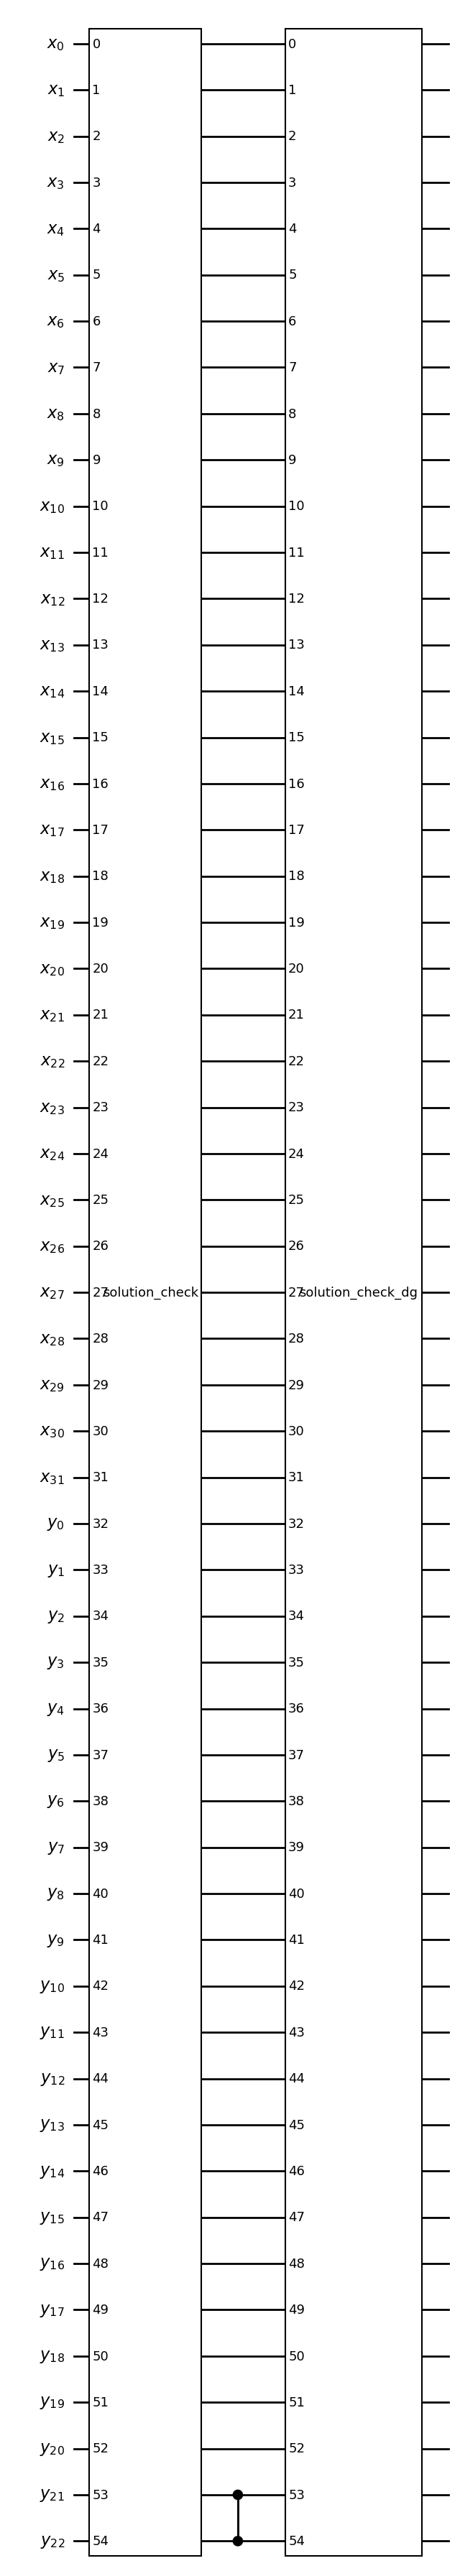

In [22]:
# Oracle (Marker circuit)

quantum_register = QuantumRegister(size=32, name="x")
ancilla_register = AncillaRegister(size=23, name="y") # one more ancilla for the CZ gate mark

marker_circuit = QuantumCircuit(quantum_register, ancilla_register, name="marker")

marker_circuit.compose(Solution_Check, inplace=True)

marker_circuit.cz(ancilla_register[21], ancilla_register[22])

marker_circuit.compose(Inv_Solution_Check, inplace=True)

###

marker_circuit.draw(output="mpl", style="bw")

In [23]:
U = marker_circuit.to_gate()

# Step 3: Prepare the initial state

Here we initialize the state as an equal superposition of all possible states.

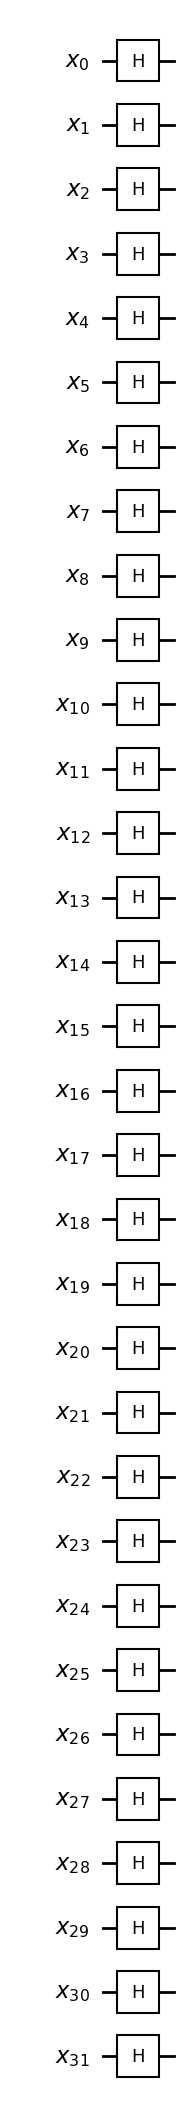

In [24]:
quantum_register = QuantumRegister(size=32, name="x")

state_preparation_circuit = QuantumCircuit(quantum_register, name="State preparation")

state_preparation_circuit.h(quantum_register)

state_preparation_circuit.draw(output="mpl", style="bw")

In [25]:
Prep = state_preparation_circuit.to_gate()

In [26]:
del list

Step 4: Diffuser

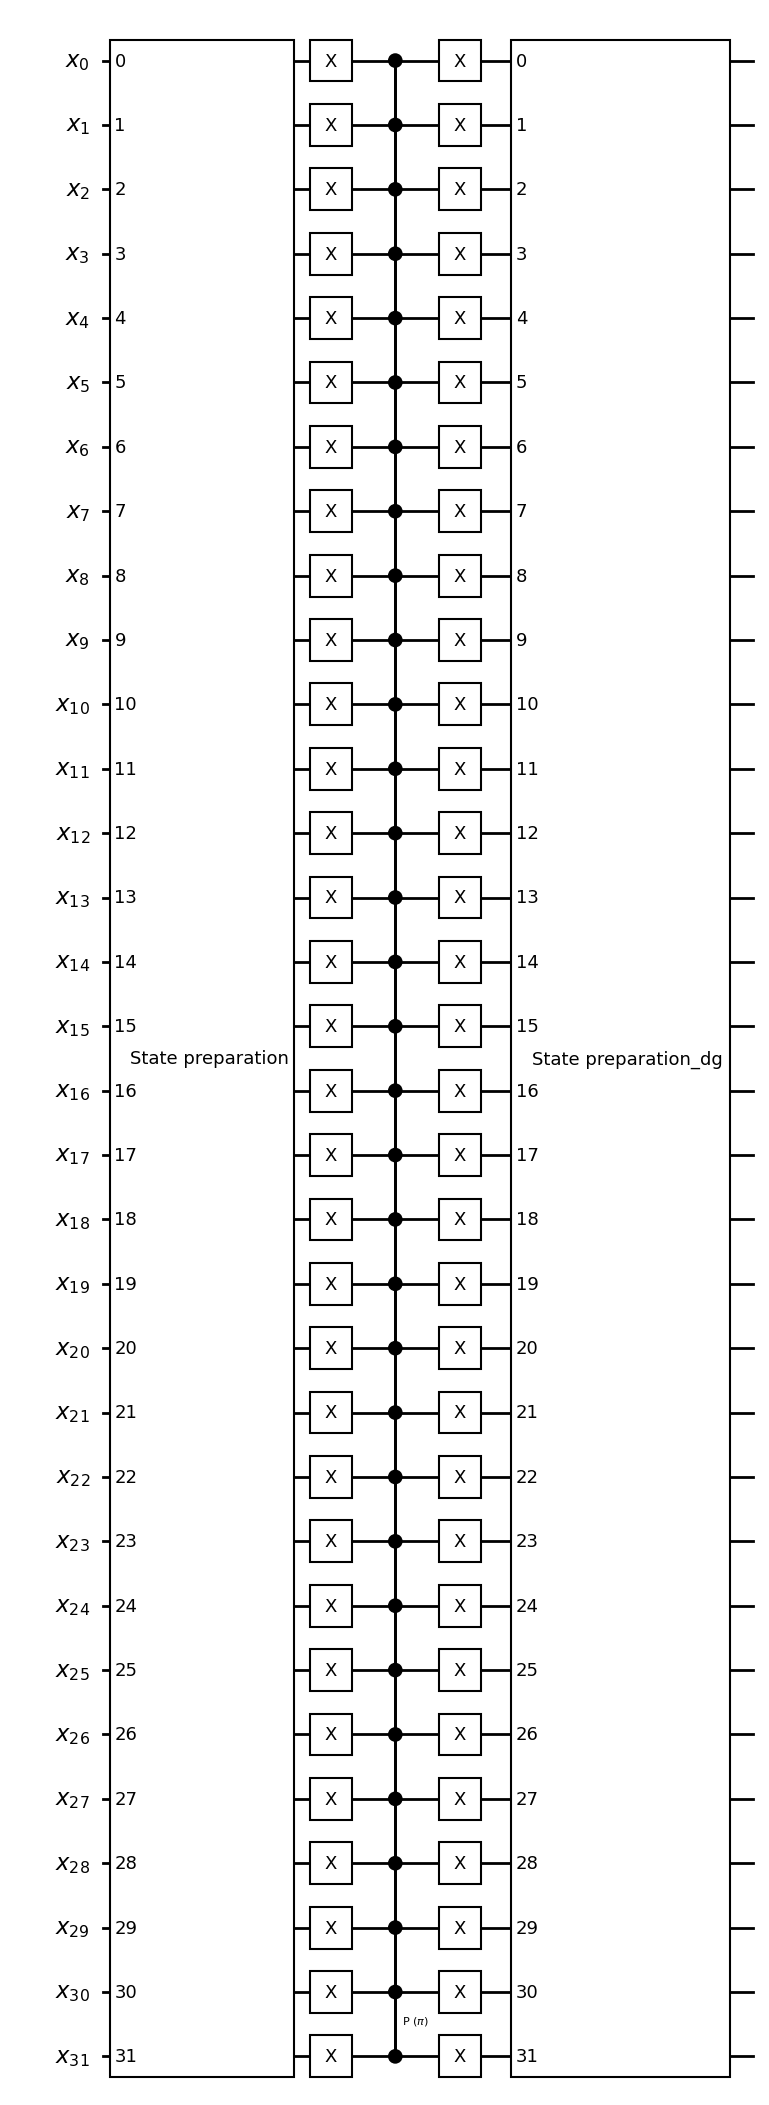

In [27]:
quantum_register = QuantumRegister(size=32, name="x")

diffuser_circuit = QuantumCircuit(quantum_register, name="diffuser")

diffuser_circuit.compose(Prep, inplace=True)

diffuser_circuit.x(quantum_register)
diffuser_circuit.mcp(np.pi, list(range(31)), 31)
diffuser_circuit.x(quantum_register)

diffuser_circuit.compose(Prep.inverse(), inplace=True)

diffuser_circuit.draw(output="mpl", style="bw")

In [28]:
D = diffuser_circuit.to_gate()

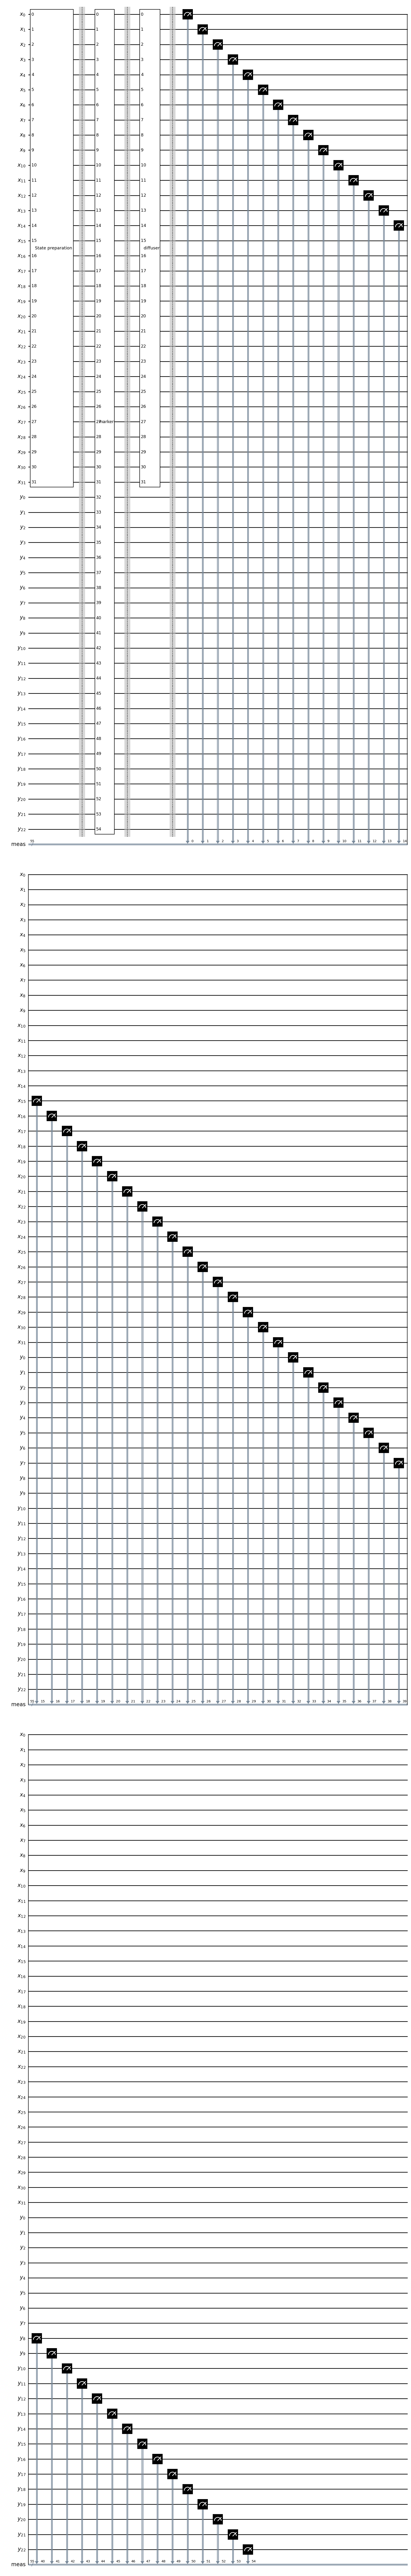

In [29]:
quantum_register = QuantumRegister(size=32, name="x")
ancilla_register = AncillaRegister(size=23, name="y")

grover_circuit = QuantumCircuit(quantum_register, ancilla_register, name="Grover circuit")

grover_circuit.compose(Prep, qubits=quantum_register[:], inplace=True)

for _ in range(1):
    grover_circuit.barrier()
    grover_circuit.compose(U, inplace=True)
    grover_circuit.barrier()
    grover_circuit.compose(D, qubits=quantum_register[:], inplace=True)

grover_circuit.measure_all()

grover_circuit.draw(output="mpl", style="bw")

In [30]:
simulator = AerSimulator(method="matrix_product_state")

In [31]:
compiled_qc = transpile(grover_circuit, simulator)

In [32]:
n = 8
N = 2**n
K = int(np.rint(np.pi / (4 * np.arcsin(1 / np.sqrt(N))) - 1/2))
K

12

In [33]:
# Impossible to run

break

SyntaxError: 'break' outside loop (<ipython-input-33-66b4fb55374f>, line 3)

In [ ]:
import time

start_time = time.time()

job = simulator.run(compiled_qc, shots=1)
result = job.result()
counts = result.get_counts()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

In [ ]:
plot_histogram(counts)

In [ ]:
# psi = Statevector(grover_circuit)
# psi.probabilities()